# Setup

In [ ]:
# Python ≥3.5 is required
import time
import math
import sys
assert sys.version_info >= (3, 5)
import copy
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import pandas as pd

import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl

import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [ ]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/MyDrive/data'
%ls

/content/gdrive/MyDrive/data
content/         model/       raw_data.csv      temp_urls.txt
laptop_data.csv  ratings.csv  raw_data.csv.csv  urls.txt


# Preprocessing Application data

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/data/laptop_data.csv')

In [ ]:
df = df.drop(['feat-count'], axis=1)

In [ ]:
csv_header = ["application", "laptop", "cpu", "gpu", "storage", "ram", "battery", "score"]

In [ ]:
df

,application,laptop,cpu,gpu,storage,ram,battery,score
0,Bioshock Infinite - Enthusiast,MSI GX60,A10-4600M,HD 7970M Enduro,1TB HDD,8GB,86Wh,38.8
1,Bioshock Infinite - Mainstream,MSI GX60,A10-4600M,HD 7970M Enduro,1TB HDD,8GB,86Wh,64.6
2,Bioshock Infinite - Value,MSI GX60,A10-4600M,HD 7970M Enduro,1TB HDD,8GB,86Wh,69.5
3,Futuremark 3DMark 11,MSI GX60,A10-4600M,HD 7970M Enduro,1TB HDD,8GB,86Wh,4683.0
4,Futuremark 3DMark Cloud Gate,MSI GX60,A10-4600M,HD 7970M Enduro,1TB HDD,8GB,86Wh,6996.0
...,...,...,...,...,...,...,...,...
3552,Metro: Last Light - Value,Alienware M17x R3 (GTX 580M),Core i7-2720QM,GTX 580M Optimus,320GB HDD,8GB,90Wh,71.3
3553,PCMark 7 (2013),Alienware M17x R3 (GTX 580M),Core i7-2720QM,GTX 580M Optimus,320GB HDD,8GB,90Wh,4354.0
3554,Tomb Raider - Enthusiast,Alienware M17x R3 (GTX 580M),Core i7-2720QM,GTX 580M Optimus,320GB HDD,8GB,90Wh,21.3
3555,Tomb Raider - Mainstream,Alienware M17x R3 (GTX 580M),Core i7-2720QM,GTX 580M Optimus,320GB HDD,8GB,90Wh,72.6


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3557 entries, 0 to 3556
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   application  3557 non-null   object 
 1   laptop       3557 non-null   object 
 2   cpu          3557 non-null   object 
 3   gpu          3433 non-null   object 
 4   storage      3557 non-null   object 
 5   ram          3557 non-null   object 
 6   battery      3557 non-null   object 
 7   score        3557 non-null   float64
dtypes: float64(1), object(7)
memory usage: 222.4+ KB


In [ ]:
df['ram'][3556]

'8GB'

In [ ]:
df['storage'] = df['storage'].str.extract(r'([^\s]+)') #+ 'GB'
df['ram'] = df['ram'].str.extract(r'(\d+)') + 'GB'
df['battery'] = df['battery'].str.extract(r'(\d+)') + 'Wh'
df

,application,laptop,cpu,gpu,storage,ram,battery,score
0,Bioshock Infinite - Enthusiast,MSI GX60,A10-4600M,HD 7970M Enduro,1TB,8GB,86Wh,38.8
1,Bioshock Infinite - Mainstream,MSI GX60,A10-4600M,HD 7970M Enduro,1TB,8GB,86Wh,64.6
2,Bioshock Infinite - Value,MSI GX60,A10-4600M,HD 7970M Enduro,1TB,8GB,86Wh,69.5
3,Futuremark 3DMark 11,MSI GX60,A10-4600M,HD 7970M Enduro,1TB,8GB,86Wh,4683.0
4,Futuremark 3DMark Cloud Gate,MSI GX60,A10-4600M,HD 7970M Enduro,1TB,8GB,86Wh,6996.0
...,...,...,...,...,...,...,...,...
3552,Metro: Last Light - Value,Alienware M17x R3 (GTX 580M),Core i7-2720QM,GTX 580M Optimus,320GB,8GB,90Wh,71.3
3553,PCMark 7 (2013),Alienware M17x R3 (GTX 580M),Core i7-2720QM,GTX 580M Optimus,320GB,8GB,90Wh,4354.0
3554,Tomb Raider - Enthusiast,Alienware M17x R3 (GTX 580M),Core i7-2720QM,GTX 580M Optimus,320GB,8GB,90Wh,21.3
3555,Tomb Raider - Mainstream,Alienware M17x R3 (GTX 580M),Core i7-2720QM,GTX 580M Optimus,320GB,8GB,90Wh,72.6


In [ ]:
df['gpu'].isnull().sum()

124

In [ ]:
df['score'].isnull().sum()

0

In [ ]:
# imputer for categorical fields - removes NaN from categorical fields
from sklearn.base import BaseEstimator, TransformerMixin
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        if columns is None:
            self.columns = X.columns
        else:
            self.columns = columns

    def fit(self, X, y=None):
        self.most_frequent_vals = pd.Series([X[col].value_counts().index[0] for col in self.columns], index=self.columns)
        return self

    def transform(self, X, y=None):
        return X.fillna(value=self.most_frequent_vals)

mf = MostFrequentImputer(columns=['laptop', 'cpu', 'gpu', 'storage', 'ram', 'battery'])
df = mf.fit_transform(df)
df

,application,laptop,cpu,gpu,storage,ram,battery,score
0,Bioshock Infinite - Enthusiast,MSI GX60,A10-4600M,HD 7970M Enduro,1TB,8GB,86Wh,38.8
1,Bioshock Infinite - Mainstream,MSI GX60,A10-4600M,HD 7970M Enduro,1TB,8GB,86Wh,64.6
2,Bioshock Infinite - Value,MSI GX60,A10-4600M,HD 7970M Enduro,1TB,8GB,86Wh,69.5
3,Futuremark 3DMark 11,MSI GX60,A10-4600M,HD 7970M Enduro,1TB,8GB,86Wh,4683.0
4,Futuremark 3DMark Cloud Gate,MSI GX60,A10-4600M,HD 7970M Enduro,1TB,8GB,86Wh,6996.0
...,...,...,...,...,...,...,...,...
3552,Metro: Last Light - Value,Alienware M17x R3 (GTX 580M),Core i7-2720QM,GTX 580M Optimus,320GB,8GB,90Wh,71.3
3553,PCMark 7 (2013),Alienware M17x R3 (GTX 580M),Core i7-2720QM,GTX 580M Optimus,320GB,8GB,90Wh,4354.0
3554,Tomb Raider - Enthusiast,Alienware M17x R3 (GTX 580M),Core i7-2720QM,GTX 580M Optimus,320GB,8GB,90Wh,21.3
3555,Tomb Raider - Mainstream,Alienware M17x R3 (GTX 580M),Core i7-2720QM,GTX 580M Optimus,320GB,8GB,90Wh,72.6


In [ ]:
app_mean_stdv = {}
app_maxr = {}
for application in df['application'].unique():
    # application = 'Cinebench R11.5 - Multi-Threaded Benchmark'
    app_idx = df['application'] == application
    ratings = df[app_idx]['score']
    mean = ratings.mean()
    stdv = ratings.std()
    minm = ratings.min()
    maxm = ratings.max()
    app_mean_stdv[application] = [mean, stdv]
    app_maxr[application] = maxm
# it normalize the score and put as rating
ratings_col = [0] * len(df)
ratings_min_max = [0] * len(df)
for i in range(len(df)):
    application = df.iloc[i]['application']
    rating = df.iloc[i]['score']
    maxm = app_maxr[application]
    ratings_min_max[i] = round(rating * 5. / maxm, 3)

ratings = pd.Series(ratings_min_max)
df['rating'] = ratings

df

,application,laptop,cpu,gpu,storage,ram,battery,score,rating
0,Bioshock Infinite - Enthusiast,MSI GX60,A10-4600M,HD 7970M Enduro,1TB,8GB,86Wh,38.8,0.826
1,Bioshock Infinite - Mainstream,MSI GX60,A10-4600M,HD 7970M Enduro,1TB,8GB,86Wh,64.6,1.229
2,Bioshock Infinite - Value,MSI GX60,A10-4600M,HD 7970M Enduro,1TB,8GB,86Wh,69.5,1.221
3,Futuremark 3DMark 11,MSI GX60,A10-4600M,HD 7970M Enduro,1TB,8GB,86Wh,4683.0,0.945
4,Futuremark 3DMark Cloud Gate,MSI GX60,A10-4600M,HD 7970M Enduro,1TB,8GB,86Wh,6996.0,0.618
...,...,...,...,...,...,...,...,...,...
3552,Metro: Last Light - Value,Alienware M17x R3 (GTX 580M),Core i7-2720QM,GTX 580M Optimus,320GB,8GB,90Wh,71.3,2.437
3553,PCMark 7 (2013),Alienware M17x R3 (GTX 580M),Core i7-2720QM,GTX 580M Optimus,320GB,8GB,90Wh,4354.0,2.687
3554,Tomb Raider - Enthusiast,Alienware M17x R3 (GTX 580M),Core i7-2720QM,GTX 580M Optimus,320GB,8GB,90Wh,21.3,0.331
3555,Tomb Raider - Mainstream,Alienware M17x R3 (GTX 580M),Core i7-2720QM,GTX 580M Optimus,320GB,8GB,90Wh,72.6,0.974


In [ ]:
df['ram'].unique(), df['storage'].unique()

(array(['8GB', '16GB', '32GB', '4GB', '12GB', '2GB', '1GB', '6GB', '64GB',
        '24GB'], dtype=object),
 array(['1TB', '1024GB', '120GB', '128GB', '256GB', '160GB', '180GB',
        '240GB', '250GB', '2x128GB', '2x128GBGB', '2x256GB', '2x500GB',
        '2x750GB', '1', '320GB', '32GB', '3x128GB', '480GB', '500GB',
        '512', '512GB', '60GB', '640GB', '64GB', '750GB', '128', '1.5TB',
        '2TB'], dtype=object))

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
cols_to_encode = ['application', 'laptop', 'cpu', 'gpu', 'storage', 'ram', 'battery']
cols_encoded = ['user_id', 'item_id', 'cpu_id', 'gpu_id', 'storage_id', 'ram_id', 'battery_id']

ord_enc = OrdinalEncoder()
encoded_vals = ord_enc.fit_transform(df[cols_to_encode])
df[cols_encoded] = encoded_vals.astype(np.int)
df

,application,laptop,cpu,gpu,storage,ram,battery,score,rating,user_id,item_id,cpu_id,gpu_id,storage_id,ram_id,battery_id
0,Bioshock Infinite - Enthusiast,MSI GX60,A10-4600M,HD 7970M Enduro,1TB,8GB,86Wh,38.8,0.826,9,144,0,86,8,9,45
1,Bioshock Infinite - Mainstream,MSI GX60,A10-4600M,HD 7970M Enduro,1TB,8GB,86Wh,64.6,1.229,10,144,0,86,8,9,45
2,Bioshock Infinite - Value,MSI GX60,A10-4600M,HD 7970M Enduro,1TB,8GB,86Wh,69.5,1.221,11,144,0,86,8,9,45
3,Futuremark 3DMark 11,MSI GX60,A10-4600M,HD 7970M Enduro,1TB,8GB,86Wh,4683.0,0.945,36,144,0,86,8,9,45
4,Futuremark 3DMark Cloud Gate,MSI GX60,A10-4600M,HD 7970M Enduro,1TB,8GB,86Wh,6996.0,0.618,37,144,0,86,8,9,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3552,Metro: Last Light - Value,Alienware M17x R3 (GTX 580M),Core i7-2720QM,GTX 580M Optimus,320GB,8GB,90Wh,71.3,2.437,51,51,50,34,18,9,47
3553,PCMark 7 (2013),Alienware M17x R3 (GTX 580M),Core i7-2720QM,GTX 580M Optimus,320GB,8GB,90Wh,4354.0,2.687,59,51,50,34,18,9,47
3554,Tomb Raider - Enthusiast,Alienware M17x R3 (GTX 580M),Core i7-2720QM,GTX 580M Optimus,320GB,8GB,90Wh,21.3,0.331,75,51,50,34,18,9,47
3555,Tomb Raider - Mainstream,Alienware M17x R3 (GTX 580M),Core i7-2720QM,GTX 580M Optimus,320GB,8GB,90Wh,72.6,0.974,76,51,50,34,18,9,47


In [ ]:
df.to_csv('/content/gdrive/MyDrive/data/raw_data.csv', index=False)


In [ ]:
df['rating'] = df['rating'].values.astype(np.float32)
n_users = df['user_id'].nunique()
n_items = df['item_id'].nunique()
min_rating = df['rating'].min()
max_rating = df['rating'].max()
n_users, n_items, min_rating, max_rating

(83, 198, 0.0, 5.0)

In [ ]:
from math import ceil
rating_buckets = np.array([0., 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
df['rating_bucket'] = df['rating'].apply(lambda x: rating_buckets[ceil(x/0.5)])

In [ ]:
max_train_user_id = round(n_users * 0.90)
max_train_user_id

75

In [ ]:
# ratings is already sorted after encoding
val_df = df[df['user_id'] > max_train_user_id]
train_df = df[df['user_id'] <= max_train_user_id]

(array([  3., 512., 490., 367., 446., 455., 376., 310., 227., 371.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

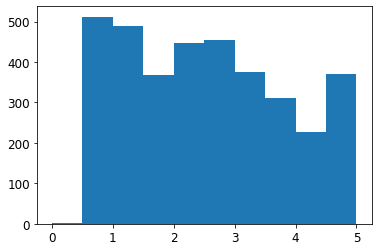

In [ ]:
# plt.hist(df['rating'], bins=[0.,0.5,1.,1.5,2.,2.5,3.,3.5,4.,4.5,5.,])
plt.hist(df['rating_bucket'], bins=rating_buckets)

In [ ]:
train_df

,application,laptop,cpu,gpu,storage,ram,battery,score,rating,user_id,item_id,cpu_id,gpu_id,storage_id,ram_id,battery_id,rating_bucket
0,Bioshock Infinite - Enthusiast,MSI GX60,A10-4600M,HD 7970M Enduro,1TB,8GB,86Wh,38.8,0.826,9,144,0,86,8,9,45,1.0
1,Bioshock Infinite - Mainstream,MSI GX60,A10-4600M,HD 7970M Enduro,1TB,8GB,86Wh,64.6,1.229,10,144,0,86,8,9,45,1.5
2,Bioshock Infinite - Value,MSI GX60,A10-4600M,HD 7970M Enduro,1TB,8GB,86Wh,69.5,1.221,11,144,0,86,8,9,45,1.5
3,Futuremark 3DMark 11,MSI GX60,A10-4600M,HD 7970M Enduro,1TB,8GB,86Wh,4683.0,0.945,36,144,0,86,8,9,45,1.0
4,Futuremark 3DMark Cloud Gate,MSI GX60,A10-4600M,HD 7970M Enduro,1TB,8GB,86Wh,6996.0,0.618,37,144,0,86,8,9,45,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3550,Futuremark 3DMark 11,Alienware M17x R3 (GTX 580M),Core i7-2720QM,GTX 580M Optimus,320GB,8GB,90Wh,3539.0,0.714,36,51,50,34,18,9,47,1.0
3551,Metro: Last Light - Mainstream,Alienware M17x R3 (GTX 580M),Core i7-2720QM,GTX 580M Optimus,320GB,8GB,90Wh,32.0,1.572,50,51,50,34,18,9,47,2.0
3552,Metro: Last Light - Value,Alienware M17x R3 (GTX 580M),Core i7-2720QM,GTX 580M Optimus,320GB,8GB,90Wh,71.3,2.437,51,51,50,34,18,9,47,2.5
3553,PCMark 7 (2013),Alienware M17x R3 (GTX 580M),Core i7-2720QM,GTX 580M Optimus,320GB,8GB,90Wh,4354.0,2.687,59,51,50,34,18,9,47,3.0


In [ ]:
val_df

,application,laptop,cpu,gpu,storage,ram,battery,score,rating,user_id,item_id,cpu_id,gpu_id,storage_id,ram_id,battery_id,rating_bucket
10,Tomb Raider - Mainstream,MSI GX60,A10-4600M,HD 7970M Enduro,1TB,8GB,86Wh,99.3,1.332,76,144,0,86,8,9,45,1.5
11,Tomb Raider - Value,MSI GX60,A10-4600M,HD 7970M Enduro,1TB,8GB,86Wh,106.1,0.985,77,144,0,86,8,9,45,1.0
65,Tomb Raider - Mainstream,Microsoft Surface Book 2 15,Core i7-8650U,HD 620 + GTX 1060,1024GB,16GB,85Wh,222.3,2.981,76,151,92,69,2,1,44,3.0
66,Tomb Raider - Value,Microsoft Surface Book 2 15,Core i7-8650U,HD 620 + GTX 1060,1024GB,16GB,85Wh,309.4,2.871,77,151,92,69,2,1,44,3.0
67,WebXPRT 2013,Microsoft Surface Book 2 15,Core i7-8650U,HD 620 + GTX 1060,1024GB,16GB,85Wh,2519.0,4.407,78,151,92,69,2,1,44,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3539,Tomb Raider - Mainstream,Alienware M17x R4 (7970M),Core i7-3720QM,HD 7970M Discrete,500GB,8GB,90Wh,106.5,1.428,76,53,61,85,22,9,47,1.5
3540,Tomb Raider - Value,Alienware M17x R4 (7970M),Core i7-3720QM,HD 7970M Discrete,500GB,8GB,90Wh,190.9,1.772,77,53,61,85,22,9,47,2.0
3541,Tomb Raider - Value,Alienware M17x R4 (7970M),Core i7-3720QM,HD 7970M Enduro,500GB,8GB,90Wh,186.9,1.734,77,53,61,86,22,9,47,2.0
3555,Tomb Raider - Mainstream,Alienware M17x R3 (GTX 580M),Core i7-2720QM,GTX 580M Optimus,320GB,8GB,90Wh,72.6,0.974,76,51,50,34,18,9,47,1.0


In [ ]:
# TODO: change dense(numpy array) to sparse
tf.random.set_seed(42)
np.random.seed(42)

def get_ratings(df, n_users, n_items, rating_buckets=False):
# returns ratings - bucketed or non-bucketed and features
    rating_col = 'rating' if rating_buckets==False else 'rating_bucket'
    ratings = np.zeros((n_users, n_items), dtype=np.float32)

    for user_id in range(n_users):
        df_ = df[df['user_id'] == user_id]
        item_ids = df_['item_id'].values
        
        ratings[user_id][item_ids] = df_[rating_col].values

    return ratings

In [ ]:
# TODO: change dense(numpy array) to sparse
tf.random.set_seed(42)
np.random.seed(42)

def get_feedback_matrix(df, n_users, n_items, rating_buckets=False):
# returns user_info, item feedback matrix, ratings for each user, and/or features
    item_data = np.zeros((n_users, n_items), dtype=np.float32)
    user_ids = np.sort(df['user_id'].unique().astype(np.float32))
    item_ids = df['item_id'].unique().astype(np.float32)
    
    for user_id in range(n_users):
        df_ = df[df['user_id'] == user_id]
        item_ids_ = df_['item_id'].values
        item_data[user_id][item_ids_] = 1.0

    return user_ids, item_ids, item_data

In [ ]:
get_ratings(df, n_users, n_items, rating_buckets=True)

array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0.5, 0. , ..., 0. , 0.5, 0. ]], dtype=float32)

Create a mapping of user: all used items

In [ ]:
all_user_ids, all_item_ids, all_item_data = get_feedback_matrix(df, n_users, n_items)
train_user_ids, train_item_ids, train_item_data = all_user_ids[:max_train_user_id+1], all_item_ids[:max_train_user_id+1], all_item_data[:max_train_user_id+1]
val_user_ids, val_item_ids, val_item_data = all_user_ids[max_train_user_id + 1:], all_item_ids[max_train_user_id + 1:], all_item_data[max_train_user_id + 1:]

# all_item_data.shape, train_item_data.shape, val_item_data.shape, val_user_ids.shape
all_user_ids.shape, all_item_ids.shape, all_item_data.shape

((83,), (198,), (83, 198))

In [ ]:
train_user_ids

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75.],
      dtype=float32)

In [ ]:
def print_status_bar(iteration, total, losses, metrics=None):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result()) for m in losses + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics, end=end)

In [ ]:
def select_negative_items(data, n_pm, n_zr):
    '''
    data : n-dimensional indicator vector specifying whether u has purchased each item i
    n_pm : num of negative items (partial-masking) sampled on the t-th iteration
    n_zr : num of negative items (zeroreconstruction regularization) sampled on the t-th iteration
    '''
    items_pm = np.zeros_like(data, dtype=np.float32)
    items_zr = np.zeros_like(data, dtype=np.float32)
    all_items = np.ones(data.shape[1], dtype=np.float32)
    for i in range(data.shape[0]):
        neg_items = np.where(data[i] == 0)[0]
        np.random.shuffle(neg_items)
        items_pm[i][neg_items[:n_pm]] = 1
        items_zr[i][neg_items[:n_zr]] = 1
    
    return items_pm, items_zr

# GAN Model

In [ ]:
class Discriminator(keras.models.Model):
    def __init__(self, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.alpha_reg = 0.05
        self.drop_prob = 0.05
        self.l2_reg = keras.regularizers.l2(self.alpha_reg)
        self.model = keras.models.Sequential([
                                              keras.layers.InputLayer(input_shape=[input_dim], name='Input Layer'),
                                              #   keras.layers.InputLayer()
                                              keras.layers.Dropout(self.drop_prob),
                                              keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal', \
                                                                 kernel_regularizer=self.l2_reg),
                                              keras.layers.Dropout(self.drop_prob),
                                              keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal', \
                                                                 kernel_regularizer=self.l2_reg),
                                              keras.layers.Dropout(self.drop_prob),
                                              keras.layers.Dense(16, activation='relu', kernel_initializer='he_normal', \
                                                                 kernel_regularizer=self.l2_reg),
                                              keras.layers.Dropout(self.drop_prob),
                                              keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_normal', \
                                                                 kernel_regularizer=self.l2_reg),
        ])

    def call(self, inputs):
        # add extra dimension to the user_id
        inputs[0] = tf.expand_dims(inputs[0], axis=1)
        inp = tf.concat(inputs, axis=1)
        out = self.model(inp)
        return out

    def get_config(self):
        # adding config data to allow model saving the config during keras.save_model
        return {'alpha_reg': self.alpha_reg, 'drop_prob': self.drop_prob}

In [ ]:
class Generator(keras.models.Model):
    def __init__(self, input_dim, output_dim, embed_size, **kwargs):
        super().__init__(**kwargs)
        self.alpha_reg = 0.05
        self.drop_prob = 0.05
        self.embed_size = embed_size
        self.l2_reg = keras.regularizers.l2(self.alpha_reg)
        self.input_dim = input_dim
        self.user_embed = keras.layers.Embedding(self.input_dim, self.embed_size, embeddings_initializer='he_normal', \
                                                 embeddings_regularizer=keras.regularizers.l2(1e-6), name='user_embed')
        self.dropout = keras.layers.Dropout(self.drop_prob)
        self.dense1 = keras.layers.Dense(256, activation='relu', kernel_initializer='he_normal', \
                                                                 kernel_regularizer=self.l2_reg, name='dense1')
        self.dense2 = keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal', \
                                                                 kernel_regularizer=self.l2_reg, name='dense2')
        self.dense3 = keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal', \
                                                                 kernel_regularizer=self.l2_reg, name='dense3')
        self.out = keras.layers.Dense(output_dim, activation='sigmoid', kernel_initializer='he_normal', \
                                                                kernel_regularizer=self.l2_reg, name='out')

    def build(self, batch_input_shape):
        super().build(batch_input_shape)

    def call(self, inputs):
        # inputs: [user_id(32, 1), item_ids(32, n_items), ratings(32, n_items)]
        user_emb = self.user_embed(inputs[0])   # shape becomes 1, embed_size for each input x
        # user_emb = tf.squeeze(user_emb, axis=1)
        inp = tf.concat([user_emb, inputs[1]], axis=1)
        x = self.dropout(inp)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        x = self.dropout(x)
        x = self.dense3(x)
        x = self.dropout(x)
        output = self.out(x)
        return output

    def get_config(self):
        # adding config data to allow model saving the config during keras.save_model
        return {'alpha_reg': self.alpha_reg, 'drop_prob': self.drop_prob}

In [ ]:
all_user_ids, all_item_ids, all_item_data = get_feedback_matrix(df, n_users, n_items)
train_user_ids, train_item_ids, train_item_data = all_user_ids[:max_train_user_id+1], all_item_ids[:max_train_user_id+1], all_item_data[:max_train_user_id+1]
val_user_ids, val_item_ids, val_item_data = all_user_ids[max_train_user_id + 1:], all_item_ids[max_train_user_id + 1:], all_item_data[max_train_user_id + 1:]

all_item_data.shape, train_item_data.shape, val_item_data.shape, val_user_ids.shape

((83, 198), (76, 198), (7, 198), (7,))

In [ ]:
user_info_shape = 1     # only have user_id but can be more than 1 uf user has features
n_features = 0
discriminator = Discriminator(user_info_shape + n_items, 1)
embedding_size = 10
generator = Generator(n_users, n_items, embed_size=embedding_size)

n_epochs = 500
batch_size = 4
eps = 10e-5

train_loader = tf.data.Dataset.from_tensor_slices((train_user_ids, train_item_data)).shuffle(buffer_size=len(train_user_ids)).batch(batch_size)
n_steps = len(train_loader) // batch_size

g_optimizer = keras.optimizers.Adam(learning_rate=0.0001)
g_mean_loss = keras.metrics.Mean(name='Generator MSE')

g_mae_fn = keras.metrics.mean_absolute_error
g_mean_mae = keras.metrics.Mean(name='Generator MAE')
g_metrics = [g_mean_mae]

d_mean_loss = keras.metrics.Mean(name='Discriminator MSE')
d_optimizer = keras.optimizers.Adam(learning_rate=0.0001)
d_metrics = []
metrics = g_metrics + d_metrics

d_losses = []
g_losses = []
g_epoch_losses = []
d_epoch_losses = []

n_pm, n_zr = 20, 20

eps = 10e-5
alpha = 0.2

reg_fn = keras.losses.mean_squared_error

In [ ]:
@tf.function
def g_train_step(user_id, real_data, pos_mask, neg_mask):
    # we want generated items to look learn to ignore negative samples. We keep only the positive + negatives feedback enties.
    # now the generator should learn to genrate this. We can add a reconstruction error to the generator's objective function.
    gnoise = tf.random.normal(shape=[real_data.shape[1]])
    noisy_data = real_data + gnoise
    with tf.GradientTape() as g_tape:
        # Generate a batch of new purchased vector
        fake_data = generator([user_id, noisy_data], training=True)
        fake_data_masked = fake_data * (pos_mask + neg_mask)
        d_out_fake = discriminator([user_id, fake_data_masked], training=False)

        g_loss = tf.reduce_mean(tf.math.log(1 - d_out_fake + eps)) + alpha * reg_fn(fake_data_masked, real_data)
        g_mae = g_mae_fn(fake_data, real_data)
    g_gradients = g_tape.gradient(g_loss, generator.trainable_weights)
    g_optimizer.apply_gradients(zip(g_gradients, generator.trainable_weights))
    return g_loss, g_mae

@tf.function
def d_train_step(user_id, real_data, pos_mask, neg_mask):
    # we want generated items to look learn to ignore negative samples. We keep only the positive + negatives feedback enties.
    # now the generator should learn to genrate this.
    with tf.GradientTape() as d_tape:
        # Generate a batch of new purchased vector
        fake_data = generator([user_id, real_data], training=False)
        fake_data_masked = fake_data * (pos_mask + neg_mask)
        d_out_fake = discriminator([user_id, fake_data_masked], training=True)
        d_out_real = discriminator([user_id, real_data], training=True)
        
        d_loss = -tf.reduce_mean(tf.math.log(d_out_real + eps) + tf.math.log(1. -d_out_fake + eps))
    d_gradients = d_tape.gradient(d_loss, discriminator.trainable_weights)
    d_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_weights))
    return d_loss

In [ ]:
# tf.debugging.set_log_device_placement(True)
for epoch in range(1, n_epochs + 1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    start_time = time.time()
    for step, (user_id, real_data) in enumerate(train_loader):
    # G step
        pos_mask = copy.deepcopy(real_data)                       # positive mask
        neg_pm, neg_zr = select_negative_items(real_data, n_pm, n_zr)   # negative masks
        neg_mask = tf.constant(neg_pm + neg_zr)     # all positive + negatives feedback mask
        
        g_loss, g_mae = g_train_step(user_id, real_data, pos_mask, neg_mask)
        g_mean_loss.update_state(g_loss)
        g_mean_mae.update_state(g_loss)

    # D step
        # negatives feedback mask
        neg_pm, _ = select_negative_items(real_data, n_pm, n_zr)
        neg_mask = tf.constant(neg_pm)
        
        d_loss = d_train_step(user_id, real_data, pos_mask, neg_mask)
        d_mean_loss.update_state(d_loss)

        losses = [g_mean_loss, d_mean_loss]
        print_status_bar(1 + step, len(train_loader), losses, metrics)

    g_epoch_losses.append(g_mean_loss.result())
    d_epoch_losses.append(d_mean_loss.result())
    
    time_elapsed = time.time() - start_time
    print("Time elepased = {} sec.".format(time_elapsed))

Epoch 1/500
19/19 - Generator MSE: -0.8841 - Discriminator MSE: 1.6393 - Generator MAE: -0.8841
Time elepased = 4.605674505233765 sec.
Epoch 2/500
19/19 - Generator MSE: -0.8618 - Discriminator MSE: 1.6225 - Generator MAE: -0.8618
Time elepased = 0.373309850692749 sec.
Epoch 3/500
19/19 - Generator MSE: -0.9146 - Discriminator MSE: 1.6323 - Generator MAE: -0.9146
Time elepased = 0.3615574836730957 sec.
Epoch 4/500
19/19 - Generator MSE: -0.9020 - Discriminator MSE: 1.5930 - Generator MAE: -0.9020
Time elepased = 0.37404346466064453 sec.
Epoch 5/500
19/19 - Generator MSE: -0.8831 - Discriminator MSE: 1.5579 - Generator MAE: -0.8831
Time elepased = 0.6262593269348145 sec.
Epoch 6/500
19/19 - Generator MSE: -0.8665 - Discriminator MSE: 1.5441 - Generator MAE: -0.8665
Time elepased = 0.3626086711883545 sec.
Epoch 7/500
19/19 - Generator MSE: -0.8691 - Discriminator MSE: 1.5221 - Generator MAE: -0.8691
Time elepased = 0.3692915439605713 sec.
Epoch 8/500
19/19 - Generator MSE: -0.8679 - Disc

In [ ]:
tf.reduce_min(d_epoch_losses)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8116104>

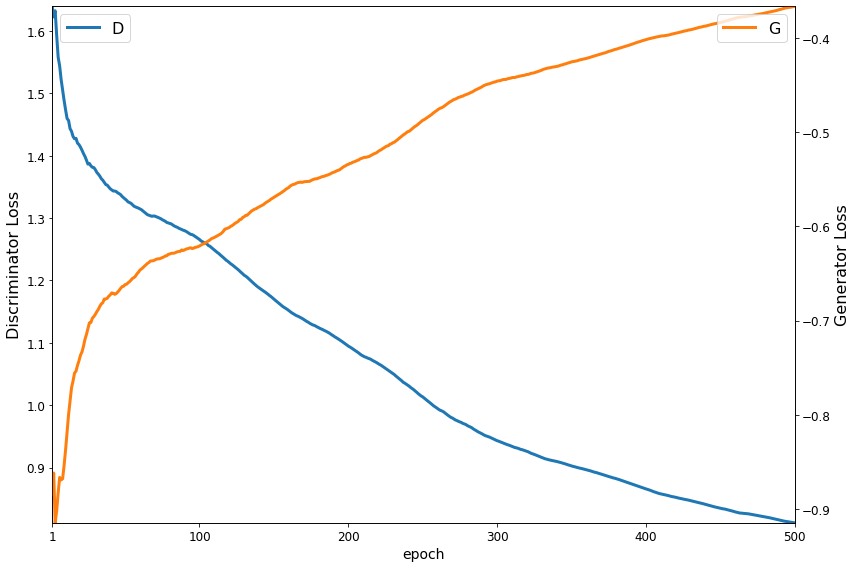

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 8))
xticks = np.arange(0, 1 + n_epochs, 5)

ax1.set_xlabel('epoch')
ax1.plot(range(1, 1 + n_epochs), d_epoch_losses, linewidth=3, color='C0', label='D')
ax1.axis([0, n_epochs, tf.reduce_min(d_epoch_losses), tf.reduce_max(d_epoch_losses)])
ax1.set_ylabel('Discriminator Loss', fontsize=16)
ax1.tick_params(axis='y')
ax1.set_xticks([1,100,200,300,400,500])
ax1.legend(loc='upper left', fontsize=16)

ax2 = ax1.twinx()
ax2.plot(range(1, 1 + n_epochs), g_epoch_losses, linewidth=3, color='C1', label='G')
ax2.axis([1, n_epochs, tf.reduce_min(g_epoch_losses), tf.reduce_max(g_epoch_losses)])
ax2.set_ylabel('Generator Loss', fontsize=16)
ax2.tick_params(axis='y')
ax2.legend(loc='upper right', fontsize=16)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("d_g_losses.png")
plt.show()

## Save the model

In [ ]:
!rm -rf model
generator.save_weights('./content/gdrive/MyDrive/data/generator_weights')
discriminator.save_weights('./content/gdrive/MyDrive/data/discriminator_weights')

In [ ]:
#!rm -rf model
#generator.save_weights('./content/gdrive/MyDrive/data/generator_weights')
#discriminator.save_weights('./content/gdrive/MyDrive/data/discriminator_weights')

user_info_shape = 1     # only have user_id but can be more than 1 uf user has features
n_features = 0
discriminator = Discriminator(user_info_shape + n_items, 1)
embedding_size = 10
generator = Generator(n_users, n_items, embed_size=embedding_size)
generator.load_weights('./content/gdrive/MyDrive/data/generator_weights')
discriminator.load_weights('./content/gdrive/MyDrive/data/discriminator_weights')

## Evaluate with implicit feedback

In [ ]:
def evaluate(user_ids, gt, pred, topN):
    # Returns evaluation metrics: Precision, Recall, NDCG
    precision_sum = 0
    recall_sum = 0
    ndcg_sum = 0
    # mmr_sum = 0
    for user_id in user_ids:
        # for a user
        hit=0
        idcg, dcg, idcg_count, ndcg = 0, 0, len(gt), 0
        # mmr = 0
        gt_items = gt[user_id]
        pred[user_id] = pred[user_id]
        
        for i in range(topN):
            if(pred[user_id][i] in set(gt[user_id])):
                hit +=1
                dcg += 1.0 / math.log2(i + 2)
            idcg += 1.0 / math.log2(i + 2)
            idcg_count = idcg_count - 1
        
        if (idcg != 0):
            ndcg += (dcg / idcg)
        
        precision_sum += hit / topN
        recall_sum += hit / len(gt[user_id])
        ndcg_sum += ndcg


    precision_N = precision_sum / len(user_ids)
    recall_N = recall_sum / len(user_ids)
    ndcg_N = ndcg_sum / len(user_ids)
    return precision_N, recall_N, ndcg_N

In [ ]:
generator, discriminator

(<__main__.Generator at 0x7fc6709694d0>,
 <__main__.Discriminator at 0x7fc665a63410>)

In [ ]:
def get_gt_and_recomm_topN(user_ids, item_data, pred_mat, topN, feedback='explicit'):
    # return user_id mapped to all used items as a dict()
    if feedback == 'explicit':
        recomm_topN = np.argsort(-pred_mat,axis=1)[:, :topN]
    else:
        recomm_topN = np.zeros((len(pred_mat), topN))
    gt = {}
    recomm = {}
    for user_id in user_ids:
        u_id = round(user_id - max_train_user_id - 1)
        gt[round(user_id)] = np.argwhere(item_data[u_id] == 1.).ravel()
        if feedback == 'explicit':
            recomm[round(user_id)] = recomm_topN[u_id]
        else:
            recomm[round(user_id)] = np.argwhere(pred_mat[u_id] == 1.).ravel()
    return gt, recomm

In [ ]:
val_pred = (generator([val_user_ids, val_item_data]) > 0.5).numpy().astype(np.float32)
topN = 10
gt_items, recomm_items = get_gt_and_recomm_topN(val_user_ids, val_item_data, val_pred, topN=10, feedback='implicit')

precision_N, recall_N, ndcg_N,_ = evaluate(val_user_ids, gt_items, recomm_items, topN=10)
print('Precision@{} = {}\nRecall@{} = {}\nNDCG@{} = {}'.format(topN, precision_N, topN, recall_N, topN, ndcg_N))

IndexError: ignored

In [ ]:
g_train_items = (generator([train_user_ids, train_item_data]) > 0.5).numpy().astype(int)
g_val_items = (generator([val_user_ids, val_item_data]) > 0.5).numpy().astype(int)

# Prediction Module

We will use the generated data to train the Prediction Module - `ScoreRegressor` model. This is based on the assumption that our Generator was able to learn the underlying **probability distribution** of the available data:

Mean shift the ratings to account for items not used by user

In [ ]:
def mean_shift(ratings):
    sum_rated = np.sum(ratings, axis=1)
    count_rated = np.sum((ratings != 0).astype(int), axis=1)
    mean_ratings = sum_rated / count_rated
    ms_ratings = np.round(ratings - mean_ratings.reshape(-1, 1), decimals=2)
    return ms_ratings, mean_ratings

# ms_ratings, mean_ratings = mean_shift(all_ratings)
# ms_ratings

In [ ]:
cols_encoded

['user_id',
 'item_id',
 'cpu_id',
 'gpu_id',
 'storage_id',
 'ram_id',
 'battery_id']

In [ ]:
feat_cols = cols_encoded[2:]
n_features = len(feat_cols)

def get_item_feat_map(df, n_features, n_items):
    # returns a array with item mapped to feature vector
    features = None
    features = np.zeros((n_items, n_features))
    df_ = df[['item_id'] + feat_cols]
    for item_id in range(n_items):
        feat = df_[df_['item_id'] == item_id].iloc[0][feat_cols].values
        features[item_id] = feat.ravel()

    return features
features = get_item_feat_map(df, n_features, n_items)
features.shape, n_items

((198, 5), 198)

Compute X_train, X_val ==> [user_id, item_id]

y_train and y_val

In [ ]:
def user_item_map(users, items, ratings):
    item_ids = None
    user_ids = None
    ratings_ = None
    for i in range(len(users)):
        pred_items = np.where(items[i] == 1)[0]    
        user_arr = np.array([users[i]]*len(pred_items))
        ratings_arr = ratings[i][pred_items]
        if user_ids is None:
            user_ids = user_arr
            item_ids = pred_items
            ratings_ = ratings_arr
        else:
            user_ids = np.r_[user_ids, user_arr]
            item_ids = np.r_[item_ids, pred_items]
            ratings_ = np.r_[ratings_, ratings_arr]

    return [user_ids.astype(int), item_ids, ratings_]

In [ ]:
g_train_item_data = (train_item_data + g_train_items)
g_val_item_data = (val_item_data + g_val_items)
g_train_item_data[np.where(g_train_item_data == 2)] = 1
g_val_item_data[np.where(g_val_item_data == 2)] = 1

all_ratings = get_ratings(df, n_users, n_items)
train_ratings = all_ratings[:max_train_user_id+1]
val_ratings = all_ratings[max_train_user_id + 1:]

ms_ratings, mean_ratings = mean_shift(all_ratings)

train_set = user_item_map(train_user_ids, g_train_item_data, ms_ratings[:max_train_user_id+1])
val_set = user_item_map(val_user_ids, g_val_item_data, ms_ratings[max_train_user_id+1:])

X_train, y_train = np.c_[train_set[0], train_set[1]], train_set[-1]
X_val, y_val = np.c_[val_set[0], val_set[1]], val_set[-1]

print('Train:', train_set[0].shape, train_set[1].shape, train_set[2].shape)
print('Val:', val_set[0].shape, val_set[1].shape, val_set[2].shape)
train_ratings.shape, val_ratings.shape

Train: (3304,) (3304,) (3304,)
Val: (390,) (390,) (390,)


((76, 198), (7, 198))

ADD FEATURES

In [ ]:
item_feat_map = get_item_feat_map(df, n_features, n_items)
item_feat_map.shape

(198, 5)

In [ ]:
item_feat_map[X_train[:, 1]].shape

(3304, 5)

In [ ]:
X_train_f = np.c_[X_train, item_feat_map[X_train[:, 1]]]
X_val_f = np.c_[X_val, item_feat_map[X_val[:, 1]]]
X_train.shape, X_train_f.shape, X_val.shape, X_val_f.shape

((3304, 2), (3304, 7), (390, 2), (390, 7))

In [ ]:
X_train, y_train

(array([[  0,  10],
        [  0,  39],
        [  0,  40],
        ...,
        [ 75, 173],
        [ 75, 177],
        [ 75, 196]]), array([-3.55, -3.55,  0.1 , ...,  2.05, -0.94, -0.67]))

## Train `ScoreReg` without using laptop features:

In [ ]:
class ScoreRegressor(keras.models.Model):
    def __init__(self, n_users, n_items, user_embed_size, item_embed_size, **kwargs):
        super().__init__(**kwargs)
        self.alpha_reg = 0.05
        self.drop_prob = 0.05
        self.user_embed_size = user_embed_size
        self.item_embed_size = item_embed_size
        self.l2_reg = keras.regularizers.l2(self.alpha_reg)
        self.user_embed = keras.layers.Embedding(n_users, self.user_embed_size, embeddings_initializer='he_normal', \
                                                 embeddings_regularizer=keras.regularizers.l2(1e-6), name='user_embed')
        self.item_embed = keras.layers.Embedding(n_items, self.item_embed_size, embeddings_initializer='he_normal', \
                                                 embeddings_regularizer=keras.regularizers.l2(1e-6), name='user_embed')
        self.dropout = keras.layers.Dropout(self.drop_prob)
        self.dense1 = keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal', \
                                                                 kernel_regularizer=self.l2_reg, name='dense1')
        self.dense2 = keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal', \
                                                                 kernel_regularizer=self.l2_reg, name='dense2')
        self.dense3 = keras.layers.Dense(16, activation='relu', kernel_initializer='he_normal', \
                                                                 kernel_regularizer=self.l2_reg, name='dense3')
        self.out = keras.layers.Dense(1, kernel_initializer='he_normal', \
                                                                 kernel_regularizer=self.l2_reg, name='out')

    def call(self, inputs):
        # inputs: [user_id, item_id] => not a list
        user_emb = self.user_embed(inputs[:, 0])
        item_emb = self.item_embed(inputs[:, 1])
        inp = tf.concat([user_emb, item_emb], axis=1)
        x = self.dropout(inp)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        x = self.dropout(x)
        x = self.dense3(x)
        x = self.dropout(x)
        output = self.out(x)
        return output

    def get_config(self):
        # adding config data to allow model saving the config during keras.save_model
        return {'alpha_reg': self.alpha_reg, 'drop_prob': self.drop_prob, 'user_embed_size': self.user_embed_size,
                'item_embed_size': self.item_embed_size}

In [ ]:
n_users, n_items

(83, 198)

In [ ]:
user_info_shape = 1     # only have user_id but can be more than 1 uf user has features
embedding_size = 10
score_model = ScoreRegressor(n_users, n_items, embedding_size, embedding_size)
n_epochs = 500
batch_size = 8

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
loss_fn = keras.losses.mean_squared_error

train_epoch_losses = []
val_epoch_losses = []

mae = keras.metrics.mean_absolute_error
metrics = [mae]

In [ ]:
score_model = ScoreRegressor(n_users, n_items, embedding_size, embedding_size)
score_model.compile(loss=loss_fn, optimizer=optimizer, metrics=metrics)

cb = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)]
history = score_model.fit(X_train, y_train, batch_size=batch_size, epochs=500, validation_data=(X_val, y_val), callbacks=cb)

Epoch 1/500
413/413 [==============================] - 3s 4ms/step - loss: 11.6079 - mean_absolute_error: 0.9234 - val_loss: 9.9701 - val_mean_absolute_error: 0.6969
Epoch 2/500
413/413 [==============================] - 1s 4ms/step - loss: 9.5584 - mean_absolute_error: 0.9230 - val_loss: 8.1297 - val_mean_absolute_error: 0.6964
Epoch 3/500
413/413 [==============================] - 2s 4ms/step - loss: 7.8968 - mean_absolute_error: 0.9211 - val_loss: 6.6451 - val_mean_absolute_error: 0.6983
Epoch 4/500
413/413 [==============================] - 1s 3ms/step - loss: 6.5503 - mean_absolute_error: 0.9192 - val_loss: 5.4480 - val_mean_absolute_error: 0.6996
Epoch 5/500
413/413 [==============================] - 1s 4ms/step - loss: 5.4727 - mean_absolute_error: 0.9190 - val_loss: 4.4855 - val_mean_absolute_error: 0.7002
Epoch 6/500
413/413 [==============================] - 1s 4ms/step - loss: 4.6097 - mean_absolute_error: 0.9178 - val_loss: 3.7134 - val_mean_absolute_error: 0.6989
Epoch 7/5

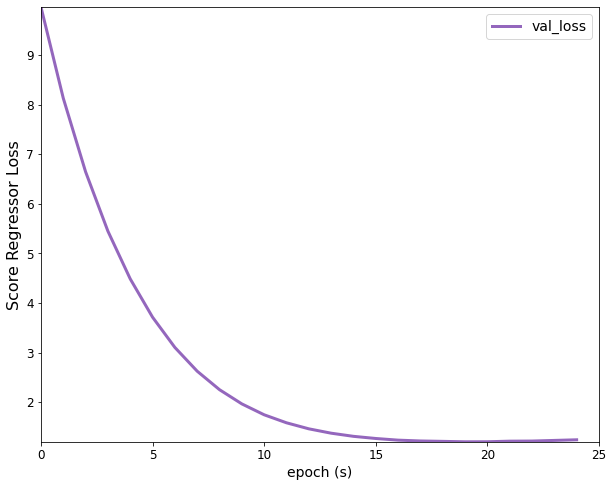

In [ ]:
y_values = history.history['val_loss']
plt.figure(figsize=(10,8))
plt.plot(np.arange(len(y_values)), y_values,  color='C4', label='val_loss', linewidth=3)
plt.axis([0, len(y_values), tf.reduce_min(y_values), tf.reduce_max(y_values)])
plt.xlabel('epoch (s)')
plt.ylabel('Score Regressor Loss', fontsize=16)
plt.legend(fontsize=14)
plt.tick_params(axis='y')

In [ ]:
min(history.history['val_loss'])

1.2002661228179932

In [ ]:
keras.models.save_model(score_model, './model/score_regressor1', save_format='tf')

INFO:tensorflow:Assets written to: ./model/score_regressor1/assets


In [ ]:
score_model = keras.models.load_model('./model/score_regressor1')

## Evaluation and Recommendation 1:

In [ ]:
y_pred = score_model.predict(X_val)
val_pred_ratings = np.zeros_like(val_item_data)
for [user_id, item_id], pred_rating in zip(X_val, y_pred):
    val_pred_ratings[user_id - max_train_user_id - 1, item_id] = pred_rating + mean_ratings[user_id]
val_pred_ratings[0]

array([0.        , 0.98901033, 0.        , 0.        , 0.        ,
       0.9582119 , 0.        , 0.        , 0.        , 1.0398428 ,
       0.999905  , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.0350093 , 0.        , 0.        ,
       0.9704623 , 0.        , 0.        , 1.0372201 , 1.0601043 ,
       0.        , 0.        , 0.        , 1.0196109 , 0.9699769 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.1196462 , 1.145606  , 0.        , 0.        ,
       0.        , 1.0633435 , 0.        , 1.0698851 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.1620896 , 0.        ,
       0.        , 1.0951976 , 1.0684243 , 0.        , 1.14641

Evaluation on Train Set:

In [ ]:
y_train_pred = score_model.predict(X_train)
train_pred_ratings = np.zeros_like(train_item_data)
for [user_id, item_id], pred_rating in zip(X_train, y_train_pred):
    train_pred_ratings[user_id, item_id] = pred_rating + mean_ratings[user_id]

In [ ]:
topN = 10
gt_items, recomm_items = get_gt_and_recomm_topN(train_user_ids, train_item_data, train_pred_ratings, topN=10, feedback='explicit')

precision_N, recall_N, ndcg_N = evaluate(train_user_ids, gt_items, recomm_items, topN=10)
print('Precision@{} = {}\nRecall@{} = {}\nNDCG@{} = {}'.format(topN, precision_N, topN, recall_N, topN, ndcg_N))

Precision@10 = 0.8868421052631575
Recall@10 = 0.4600667098002715
NDCG@10 = 0.9013323824445548


Evaluation on Validation Set:

In [ ]:
topN = 10
gt_items, recomm_items = get_gt_and_recomm_topN(val_user_ids, val_item_data, val_pred_ratings, topN=10, feedback='explicit')

precision_N, recall_N, ndcg_N = evaluate(val_user_ids, gt_items, recomm_items, topN=10)
print('Precision@{} = {}\nRecall@{} = {}\nNDCG@{} = {}'.format(topN, precision_N, topN, recall_N, topN, ndcg_N))

Precision@10 = 1.0
Recall@10 = 0.22839835623881388
NDCG@10 = 1.0


In [ ]:
recomm_items

{76: array([ 68, 171,  74,  47, 140, 135,  46, 138,  98, 172]),
 77: array([ 40,  68, 171,  74,  47,  95, 140, 135, 152,  46]),
 78: array([171,  74,  47,  46, 138,  20, 124, 161, 184, 172]),
 79: array([ 73,  41,  74,  95, 141,  20, 156, 124, 161,  42]),
 80: array([ 40,  73,  41,  95, 152, 159, 156, 147,  42, 131]),
 81: array([ 40,  73,  41, 171,  74,  95, 140, 141, 135, 152]),
 82: array([ 40,  73,  41,  68, 171,  74,  47,  95, 140, 141])}

## Train `ScoreReg` using laptop features:

In [ ]:
class ScoreRegressor(keras.models.Model):
    def __init__(self, n_users, n_items, user_embed_size, item_embed_size, **kwargs):
        super().__init__(**kwargs)
        self.alpha_reg = 0.05
        self.drop_prob = 0.05
        self.user_embed_size = user_embed_size
        self.item_embed_size = item_embed_size
        self.l2_reg = keras.regularizers.l2(self.alpha_reg)
        self.user_embed = keras.layers.Embedding(n_users, self.user_embed_size, embeddings_initializer='he_normal', \
                                                 embeddings_regularizer=keras.regularizers.l2(1e-6), name='user_embed')
        self.item_embed = keras.layers.Embedding(n_items, self.item_embed_size, embeddings_initializer='he_normal', \
                                                 embeddings_regularizer=keras.regularizers.l2(1e-6), name='user_embed')
        self.dropout = keras.layers.Dropout(self.drop_prob)
        self.dense1 = keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal', \
                                                                 kernel_regularizer=self.l2_reg, name='dense1')
        self.dense2 = keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal', \
                                                                 kernel_regularizer=self.l2_reg, name='dense1')
        self.dense3 = keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal', \
                                                                 kernel_regularizer=self.l2_reg, name='dense2')
        self.dense4 = keras.layers.Dense(16, activation='relu', kernel_initializer='he_normal', \
                                                                 kernel_regularizer=self.l2_reg, name='dense3')
        self.out = keras.layers.Dense(1, kernel_initializer='he_normal', \
                                                                 kernel_regularizer=self.l2_reg, name='out')

    def call(self, inputs):
        # inputs: [user_id, item_id, features] => not a list
        user_emb = self.user_embed(inputs[:, 0])
        item_emb = self.item_embed(inputs[:, 1])
        features = inputs[:, 2:]
        inp = tf.concat([user_emb, item_emb, features], axis=1)
        x = self.dropout(inp)
        x = self.dense1(x)
        x = self.dropout(x)
        # x = self.dense2(x)
        # x = self.dropout(x)
        x = self.dense3(x)
        x = self.dropout(x)
        x = self.dense4(x)
        x = self.dropout(x)
        output = self.out(x)
        return output

    def get_config(self):
        # adding config data to allow model saving the config during keras.save_model
        return {'alpha_reg': self.alpha_reg, 'drop_prob': self.drop_prob, 'user_embed_size': self.user_embed_size,
                'item_embed_size': self.item_embed_size}

In [ ]:
user_info_shape = 1     # only have user_id but can be more than 1 uf user has features
embedding_size = 10
score_model = ScoreRegressor(n_users, n_items, embedding_size, 1.5 * embedding_size)
n_epochs = 500
batch_size = 8

optimizer = keras.optimizers.Adam(learning_rate=0.00005)
loss_fn = keras.losses.mean_squared_error

train_epoch_losses = []
val_epoch_losses = []

mae = keras.metrics.mean_absolute_error
metrics = [mae]

In [ ]:
score_model = ScoreRegressor(n_users, n_items, embedding_size, embedding_size)
score_model.compile(loss=loss_fn, optimizer=optimizer, metrics=metrics)

cb = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)]
history = score_model.fit(X_train_f, y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_val_f, y_val), callbacks=cb)

Epoch 1/500
413/413 [==============================] - 2s 4ms/step - loss: 273.6794 - mean_absolute_error: 12.1279 - val_loss: 42.1222 - val_mean_absolute_error: 4.6304
Epoch 2/500
413/413 [==============================] - 1s 4ms/step - loss: 143.4250 - mean_absolute_error: 8.5706 - val_loss: 28.2334 - val_mean_absolute_error: 3.5311
Epoch 3/500
413/413 [==============================] - 2s 4ms/step - loss: 101.2252 - mean_absolute_error: 7.1255 - val_loss: 22.0599 - val_mean_absolute_error: 2.7680
Epoch 4/500
413/413 [==============================] - 1s 4ms/step - loss: 68.4938 - mean_absolute_error: 5.7556 - val_loss: 19.6750 - val_mean_absolute_error: 2.4441
Epoch 5/500
413/413 [==============================] - 2s 4ms/step - loss: 46.1227 - mean_absolute_error: 4.5429 - val_loss: 14.7324 - val_mean_absolute_error: 1.8044
Epoch 6/500
413/413 [==============================] - 1s 3ms/step - loss: 36.0413 - mean_absolute_error: 3.8414 - val_loss: 13.4564 - val_mean_absolute_error: 1

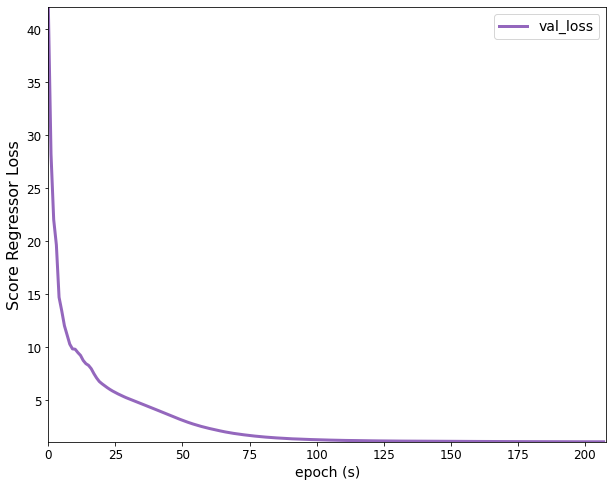

In [ ]:
y_values = history.history['val_loss']
plt.figure(figsize=(10,8))
plt.plot(np.arange(len(y_values)), y_values,  color='C4', label='val_loss', linewidth=3)
plt.axis([0, len(y_values), tf.reduce_min(y_values), tf.reduce_max(y_values)])
plt.xlabel('epoch (s)')
plt.ylabel('Score Regressor Loss', fontsize=16)
plt.legend(fontsize=14)
plt.tick_params(axis='y')
plt.savefig("Score_Regressor.png")
plt.show()

## Evaluation and Recommendation 2:

In [ ]:
y_pred = score_model.predict(X_val_f)
val_pred_ratings = np.zeros_like(val_item_data)
for i in range(len(X_val_f)):
    row = X_val_f[i]
    user_id, item_id = round(row[0]), round(row[1])
    pred_rating = y_val[i]
    val_pred_ratings[user_id - max_train_user_id - 1, item_id] = pred_rating + mean_ratings[user_id]
val_pred_ratings[-1], mean_ratings[82]

(array([0.        , 0.08253761, 0.        , 0.        , 0.        ,
        0.12253762, 0.        , 0.        , 0.        , 0.4125376 ,
        0.43253762, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.2825376 , 0.        , 0.        , 0.        , 0.        ,
        0.13253762, 0.        , 0.30253762, 0.        , 0.12253762,
        0.14253762, 0.        , 0.        , 0.16253762, 0.15253761,
        0.18253762, 0.        , 0.        , 0.17253761, 0.4125376 ,
        0.8325376 , 0.6425376 , 0.6425376 , 0.        , 0.        ,
        0.        , 0.4025376 , 0.39253762, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.15253761, 0.        , 0.14253762, 0.11253762, 0.11253762,
        0.13253762, 0.        , 0.        , 0.4125376 , 0.        ,
        0.        , 0.4025376 , 0.5225376 , 1.23

In [ ]:
np.sum(mean_ratings[0] == 0.40173143)

0

Evaluation on Train Set:

In [ ]:
y_pred = score_model.predict(X_train_f)
train_pred_ratings = np.zeros_like(train_item_data)
for i in range(len(X_train)):
    row = X_train[i]
    user_id, item_id = row[0], row[1]
    pred_rating = y_train[i]
    train_pred_ratings[user_id, item_id] = pred_rating + mean_ratings[user_id]
# train_pred_ratings[0]

In [ ]:
topN = 10
gt_items, recomm_items = get_gt_and_recomm_topN(train_user_ids, train_item_data, train_pred_ratings, topN=10, feedback='explicit')

precision_N, recall_N, ndcg_N = evaluate(train_user_ids, gt_items, recomm_items, topN=10)
print('Precision@{} = {}\nRecall@{} = {}\nNDCG@{} = {}'.format(topN, precision_N, topN, recall_N, topN, ndcg_N))

Precision@10 = 0.9223684210526315
Recall@10 = 0.5038087955653835
NDCG@10 = 0.94480706294652


Evaluation on Validation Set:

In [ ]:
topN = 10
gt_items, recomm_items = get_gt_and_recomm_topN(val_user_ids, val_item_data, val_pred_ratings, topN=10, feedback='explicit')

precision_N, recall_N, ndcg_N = evaluate(val_user_ids, gt_items, recomm_items, topN=10)
print('Precision@{} = {}\nRecall@{} = {}\nNDCG@{} = {}'.format(topN, precision_N, topN, recall_N, topN, ndcg_N))

Precision@10 = 1.0
Recall@10 = 0.22839835623881388
NDCG@10 = 1.0


In [ ]:
recomm_items

{76: array([ 74,  10, 151,  47,   9,  72, 105, 140, 172,  46]),
 77: array([ 74,   9,  72,  10, 140,  40, 151, 152, 105, 172]),
 78: array([ 72, 151, 142, 143, 161,  20,  74, 105, 172, 167]),
 79: array([ 73, 141,  42, 151, 157, 143,  95, 134,  20, 111]),
 80: array([ 73, 147, 134,  42, 173,  95, 159, 157,  91,  41]),
 81: array([152, 173, 147,  91,  40, 157, 159,  42,  99, 128]),
 82: array([ 73, 134, 141,  40, 173,  42,  41, 147,  74,  72])}

In [ ]:
gt_items[76]

array([  1,   5,   9,  10,  27,  30,  33,  34,  38,  46,  47,  51,  53,
        68,  71,  72,  74,  78,  82,  89,  98,  99, 100, 105, 119, 122,
       129, 132, 133, 135, 138, 139, 140, 144, 145, 146, 151, 154, 164,
       170, 171, 172, 177, 196])

# Example Recommendation:

In [ ]:
np.random.seed(42)
some_user_id = np.random.randint(max_train_user_id)
recomm_items[80]

array([ 73, 147, 134,  42, 173,  95, 159, 157,  91,  41])

In [ ]:
applications = df['application'].unique()
applications[some_user_id]

'PCMark 8 - Home'

In [ ]:
laptops = df['laptop'].unique()
laptops[recomm_items[80]]

array(['Alienware 17', 'Microsoft Surface Laptop 4 15 Ryzen 7',
       'Razer Blade (late 2012)', 'Lenovo Yoga C930',
       'Clevo W110ER (Eurocom Monster 1.0)', 'MSI GT680R', 'HP Envy 13',
       'Microsoft Surface Pro (2017)', 'Alienware M18x R2',
       'Microsoft Surface Laptop 3 15 Core i7'], dtype=object)